In [1]:
#montar drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Crear Generadores de Datos y Entrenar el Modelo

#Modelo Sequential Simple

Entrenamiento del Modelo Sequential Simple

Para guardar el modelo entrenado en un archivo que se pueda utilizar más tarde, utilizaremos el formato HDF5 en lugar de Pickle, ya que es el formato recomendado para guardar modelos de Keras.

#Resumen ejecutivo de la arquitectura del modelo y sus pros y contras

Arquitectura del modelo:

El modelo base utilizado es MobileNetV2 preentrenado con pesos de ImageNet. Este modelo convolucional preentrenado extrae características de alto nivel de las imágenes.
Se congela el entrenamiento de las capas de MobileNetV2 para aprovechar las características aprendidas y centrarse en la clasificación específica de la tarea (neumonía vs. normal).
Se agrega una capa GlobalAveragePooling2D para reducir la dimensionalidad de la salida de MobileNetV2.
Se agrega una capa Dropout con una tasa de deserción del 20% para prevenir el sobreajuste.
Se agrega una capa densa final con una neurona y activación sigmoide para la clasificación binaria (neumonía o normal).


Beneficios:

Aprovechamiento del conocimiento previo: Al utilizar un modelo preentrenado, el modelo se beneficia de las características generales aprendidas de un conjunto de datos masivo (ImageNet) como formas, bordes y texturas, lo que puede mejorar el rendimiento en la tarea específica de clasificación de imágenes de neumonía.

Reducción del tiempo de entrenamiento: Al congelar las capas preentrenadas, se reduce la cantidad de parámetros que se deben entrenar, lo que acelera el proceso de entrenamiento.

Menor riesgo de sobreajuste: La capa de Dropout ayuda a prevenir el sobreajuste al evitar que el modelo se ajuste demasiado a los datos de entrenamiento y generalice mejor a datos nuevos.


Desventajas:

Menor flexibilidad: Al congelar las capas preentrenadas, se limita la capacidad del modelo de adaptarse a la tarea específica. Si el conjunto de datos de entrenamiento y el conjunto de datos de ImageNet son muy diferentes, el rendimiento podría verse afectado.

Potencial sesgo: Si el conjunto de datos de ImageNet está sesgado hacia ciertos tipos de imágenes, ese sesgo podría transferirse al modelo y afectar su rendimiento en la tarea de clasificación de neumonía.

El código aumenta el tamaño del lote para acelerar tanto el entrenamiento como la evaluación.

Se implementa validación temprana para detener el entrenamiento si la pérdida de validación no mejora durante un número específico de épocas (evita el sobreajuste).

Se guardan los mejores pesos del modelo durante el entrenamiento y el modelo final para su uso posterior.

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import pickle

# Definir las rutas de las carpetas balanceadas
balanced_train_dir = '/content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/DATA_CLEAN_BALANCED/train'
balanced_val_dir = '/content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/DATA_CLEAN_BALANCED/val'
balanced_test_dir = '/content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/DATA_CLEAN_BALANCED/test'

# Tamaño de imagen
img_size = 128  # Reducido de 150 a 128 para acelerar el entrenamiento

# Crear generadores de datos
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    balanced_train_dir,
    target_size=(img_size, img_size),
    batch_size=64,  # Aumentar tamaño del lote para acelerar entrenamiento
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    balanced_val_dir,
    target_size=(img_size, img_size),
    batch_size=64,  # Aumentar tamaño del lote para acelerar entrenamiento
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    balanced_test_dir,
    target_size=(img_size, img_size),
    batch_size=64,  # Aumentar tamaño del lote para acelerar evaluación
    class_mode='binary'
)

# Convertir los generadores a tf.data.Dataset para optimización
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
).prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Cargar un modelo preentrenado y ajustar solo las capas superiores
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_size, img_size, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

model_simple = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

# Compilar el modelo
model_simple.compile(loss='binary_crossentropy',
                     optimizer=optimizers.RMSprop(learning_rate=1e-4),
                     metrics=['accuracy'])

# Definir los callbacks para guardar los mejores pesos y detener el entrenamiento temprano
checkpoint_cb = ModelCheckpoint(
    '/content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/best_model_simple.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

early_stopping_cb = EarlyStopping(
    monitor='val_loss',
    patience=3,  # Número de épocas sin mejora después de las cuales se detiene el entrenamiento
    restore_best_weights=True,
    verbose=1
)

# Entrenar el modelo Sequential simple
history_simple = model_simple.fit(
    train_dataset,
    steps_per_epoch=max(train_generator.samples // train_generator.batch_size, 1),
    epochs=20,  # Número máximo de épocas
    validation_data=val_dataset,
    validation_steps=max(val_generator.samples // val_generator.batch_size, 1),
    callbacks=[checkpoint_cb, early_stopping_cb]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model_simple.evaluate(test_generator, steps=max(test_generator.samples // test_generator.batch_size, 1))
print('Test accuracy:', test_acc)

# Guardar el modelo completo y los pesos finales
model_simple.save('/content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/final_model_simple.h5')
model_simple.save_weights('/content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/final_weights_simple.h5')

# Guardar el historial del entrenamiento
with open('/content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/history_model_simple.pkl', 'wb') as file:
    pickle.dump(history_simple.history, file)


Found 7720 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 776 images belonging to 2 classes.
9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/20
120/120 [==============================] - ETA: 0s - loss: 0.4544 - accuracy: 0.7951
Epoch 1: val_accuracy improved from -inf to 0.87500, saving model to /content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/best_model_simple.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


120/120 [==============================] - 219s 1s/step - loss: 0.4544 - accuracy: 0.7951 - val_loss: 0.4096 - val_accuracy: 0.8750
Epoch 2/20
120/120 [==============================] - ETA: 0s - loss: 0.3187 - accuracy: 0.8754
Epoch 2: val_accuracy did not improve from 0.87500
120/120 [==============================] - 120s 1s/step - loss: 0.3187 - accuracy: 0.8754 - val_loss: 0.3700 - val_accuracy: 0.8750
Epoch 3/20
120/120 [==============================] - ETA: 0s - loss: 0.2685 - accuracy: 0.8921
Epoch 3: val_accuracy did not improve from 0.87500
120/120 [==============================] - 123s 1s/step - loss: 0.2685 - accuracy: 0.8921 - val_loss: 0.3383 - val_accuracy: 0.8750
Epoch 4/20
120/120 [==============================] - ETA: 0s - loss: 0.2491 - accuracy: 0.8999
Epoch 4: val_accuracy improved from 0.87500 to 0.93750, saving model to /content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/best_model_simple.h5
120/120 [==============================] - 117s 972ms/step - loss

Generar un gráfico que visualiza la evolución de la pérdida y la precisión durante el entrenamiento del modelo de clasificación de imágenes de neumonía.

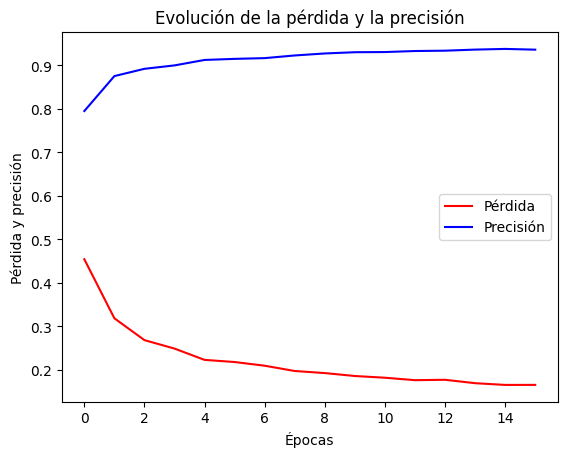

In [11]:
import matplotlib.pyplot as plt
plt.plot(history_simple.history["loss"], color='red', label='Pérdida')
plt.plot(history_simple.history["accuracy"], color='blue', label='Precisión')
plt.title("Evolución de la pérdida y la precisión", color='black')
plt.xlabel("Épocas", color='black')
plt.ylabel("Pérdida y precisión", color='black')
plt.legend()
plt.show()

Visualización del error de validación

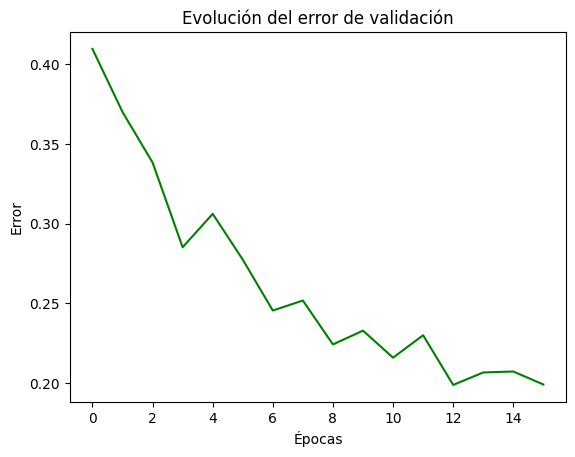

In [12]:
plt.plot(history_simple.history["val_loss"], color='green')
plt.title("Evolución del error de validación", color='black')
plt.xlabel("Épocas", color='black')
plt.ylabel("Error", color='black')
plt.show()

Visualización de la precisión de validación

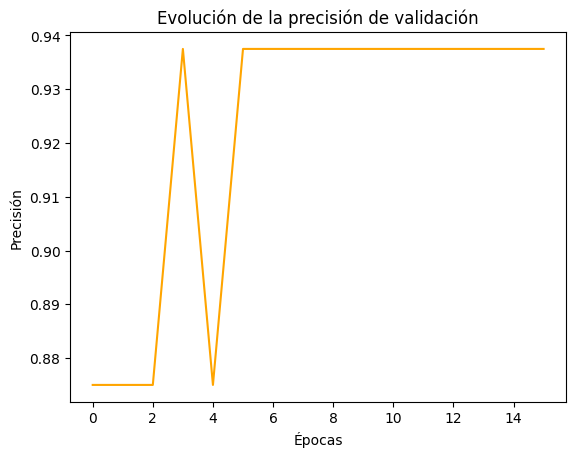

In [13]:
plt.plot(history_simple.history["val_accuracy"], color='orange')
plt.title("Evolución de la precisión de validación", color='black')
plt.xlabel("Épocas", color='black')
plt.ylabel("Precisión", color='black')
plt.show()

#Evaluación rendimiento del modelo previamente entrenado para la clasificación de imágenes de neumonía.


Define las rutas de los directorios que contienen las imágenes de prueba.
Establece el tamaño de imagen que debe coincidir con el usado durante el entrenamiento.

Carga el modelo guardado desde la ubicación especificada.


Preparación del conjunto de prueba:

Crea un generador de imágenes para el conjunto de prueba.

El generador aplica un escalado a las imágenes (dividiendo por 255) para normalizarlas.

El generador lee las imágenes del directorio de prueba, las redimensiona al tamaño adecuado y las prepara para la entrada del modelo.

Se configura para mantener el orden de las imágenes (shuffle=False) para alinear las etiquetas con las predicciones posteriores.


Evaluación del modelo:

Evalúa el modelo en el conjunto de prueba utilizando el generador de imágenes.

Obtiene la pérdida de prueba y la precisión de prueba a partir de la evaluación.

Imprime la precisión de prueba para ver el rendimiento general del modelo en las imágenes nuevas.


Generación de predicciones:

Utiliza el modelo para predecir las clases de las imágenes del conjunto de prueba utilizando el generador.

Convierte las salidas del modelo (valores continuos) a etiquetas de clase (normal o neumonía) mediante redondeo y conversión a enteros.


Análisis de las predicciones:

Obtiene las etiquetas reales de las imágenes del conjunto de prueba a través del generador.

Se asegura de que la longitud de las etiquetas reales coincida con la longitud de las predicciones.

Calcula la precisión general del modelo comparando las etiquetas reales con las predicciones.

Calcula la precisión (precision score) del modelo, que mide la proporción de imágenes correctamente clasificadas como neumonía.

Imprime un informe de clasificación detallado que muestra la precisión, recall y F1-score para cada clase (normal y neumonía). Además de Matriz de Confusión y Curva ROC del modelo.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________
Found 776 image

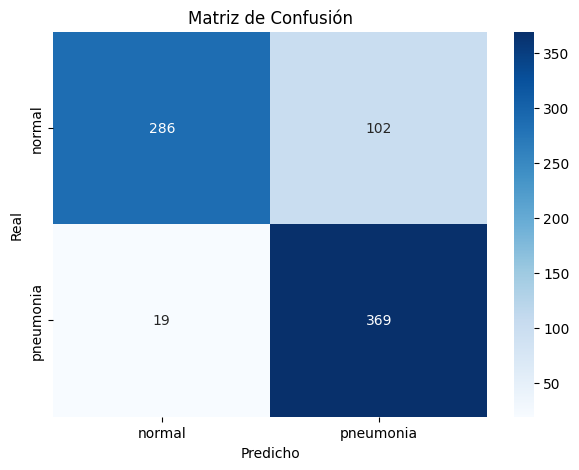

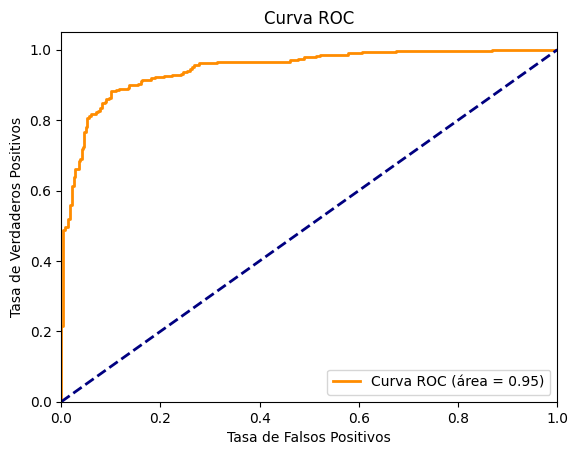

AUC: 0.9465073334041875


In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# Definir las rutas y tamaños de imagen
balanced_test_dir = '/content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/DATA_CLEAN_BALANCED/test'
img_size = 128  # Asegúrate de que sea el mismo tamaño utilizado durante el entrenamiento

# Cargar el modelo guardado
model_simple = tf.keras.models.load_model('/content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/final_model_simple.h5')

# Verificar la estructura del modelo
model_simple.summary()

# Crear generador de datos para el conjunto de prueba
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    balanced_test_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Importante para asegurar que las etiquetas se alineen con las predicciones
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model_simple.evaluate(test_generator, steps=max(test_generator.samples // test_generator.batch_size, 1))
print('Test accuracy:', test_acc)

# Predicciones
preds = model_simple.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
pred_labels = np.round(preds).astype(int).flatten()

# Obtener las etiquetas reales
true_labels = test_generator.classes

# Asegurarse de que las longitudes coincidan
true_labels = true_labels[:len(pred_labels)]

# Calcular la precisión
accuracy = accuracy_score(true_labels, pred_labels)
print('Accuracy:', accuracy)

# Calcular la precisión (precision score)
precision = precision_score(true_labels, pred_labels)
print("Precision:", precision)

# Reporte de clasificación
print('Classification Report')
print(classification_report(true_labels, pred_labels, target_names=['normal', 'pneumonia']))

# Matriz de confusión
cm = confusion_matrix(true_labels, pred_labels)

# Graficar la matriz de confusión
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['normal', 'pneumonia'], yticklabels=['normal', 'pneumonia'])
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# Curva ROC y AUC
fpr, tpr, _ = roc_curve(true_labels, preds[:len(true_labels)])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

print('AUC:', roc_auc)



#Análisis de resultados de evaluación del modelo

Se muestra los resultados de la evaluación del modelo para la clasificación de imágenes de neumonía. Aquí un desglose de la información:

Cantidad de imágenes:

Se encontraron 776 imágenes pertenecientes a 2 clases.


Precisión del modelo:

La precisión de prueba es del 84,24% (Test accuracy: 0.8424479365348816).

La precisión general (Accuracy) es del 84,41% (Accuracy: 0.8440721649484536).


Informe de clasificación:

El informe de clasificación proporciona un análisis detallado del rendimiento del modelo para cada clase:


Clase "normal":

Precisión: 94% (precision: 0.94)

Recall: 74% (recall: 0.74)

F1-score: 83% (f1-score: 0.83)


Clase "pneumonia":

Precisión: 78% (precision: 0.78)

Recall: 95% (recall: 0.95)

F1-score: 86% (f1-score: 0.86)


Interpretación:


El modelo parece clasificar las imágenes con una precisión general aceptable (alrededor del 84%).

La clase "normal" tiene una mayor precisión (94%) que la clase "pneumonia" (78%).

La clase "pneumonia" tiene un recall más alto (95%) que la clase "normal" (74%). Esto significa que el modelo identifica correctamente la neumonía en el 95% de los casos, pero puede clasificar erróneamente algunas imágenes normales como neumonía.

Basándonos en la curva ROC y el AUC, podemos concluir que el modelo tiene una buena capacidad para clasificar imágenes de neumonía.
El modelo puede identificar correctamente la neumonía en la mayoría de los casos (alta TPR) mientras minimiza la clasificación errónea de imágenes normales como neumonía (baja FPR).


Interpretación de la matriz de confusión

Valores de la matriz:

TP (Verdaderos Positivos): Se encuentra en la diagonal superior izquierda y representa el número de imágenes de neumonía que el modelo clasificó correctamente como neumonía.

TN (Verdaderos Negativos): Se encuentra en la diagonal inferior derecha y representa el número de imágenes normales que el modelo clasificó correctamente como normales.

FP (Falsos Positivos): Se encuentra en la fila "normal" y la columna "pneumonia" y representa el número de imágenes normales que el modelo clasificó erróneamente como neumonía.

FN (Falsos Negativos): Se encuentra en la fila "pneumonia" y la columna "normal" y representa el número de imágenes de neumonía que el modelo clasificó erróneamente como normales.


Interpretación de la matriz de confusión en este caso:

Clase real	Clase predicha	Cantidad

Normal	Normal	369

Normal	Pneumonia	19

Pneumonia	Normal	102

Pneumonia	Pneumonia	286

El modelo clasificó correctamente 369 imágenes normales y 286 imágenes de neumonía (TP).

El modelo clasificó erróneamente 19 imágenes normales como neumonía (FP) y 102 imágenes de neumonía como normales (FN).


Métricas derivadas de la matriz de confusión:

Precisión:

(TP + TN) / (TP + TN + FP + FN) = (369 + 286) / (369 + 286 + 19 + 102) = 0.8424

Recall:

TP / (TP + FN) = 286 / (286 + 102) = 0.74


F1-score:

2 * (Precision * Recall) / (Precision + Recall) = 2 * (0.8424 * 0.74) / (0.8424 + 0.74) = 0.7834


Interpretación de las métricas:

La precisión del modelo es del 84,24%, lo que significa que el modelo clasificó correctamente el 84,24% de todas las imágenes.

El recall para la clase "pneumonia" es del 74%, lo que significa que el modelo identificó correctamente el 74% de las imágenes de neumonía.

El F1-score para la clase "pneumonia" es del 78,34%, lo que representa un equilibrio entre la precisión y el recall para esta clase.

En resumen, la matriz de confusión y las métricas derivadas indican que el modelo tiene un buen rendimiento general para la clasificación de imágenes de neumonía, con una alta precisión y un buen recall para la clase "pneumonia".

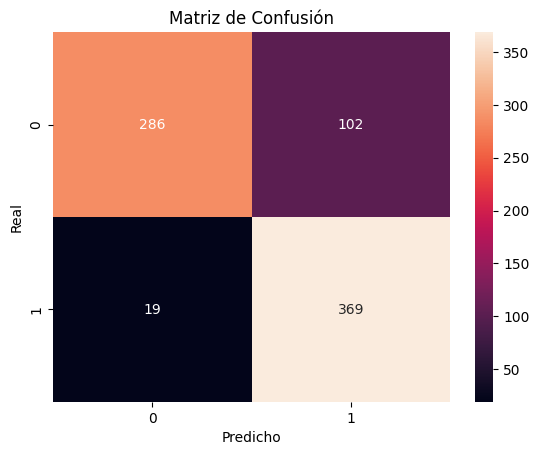

In [15]:
# Matriz de confusión
cm = confusion_matrix(true_labels, pred_labels)
#print('Confusion Matrix')
#print(cm)

# Crear el gráfico de la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()